# Exploratory Data Analysis

In [1]:
%matplotlib inline

# Filter warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark import sql, SparkContext, SparkConf
from pyspark.sql.functions import *

plt.rcParams.update({'font.size': 18})

In [2]:
# Create spark session
spark = SparkSession.builder.appName("project").getOrCreate()

# Load data

In [8]:
# load data
df = spark.read.csv('../data/emdat_public_cleaned.csv', inferSchema = True, header = True) 
df.createOrReplaceTempView("raw_table") # create table for sql query

# print data size and display sample
print("Data size:", (df.count(), len(df.columns)))

cols = [
    'year', 'continent', 'disaster_type', 
    'no_injured','no_affected', 
    "total_damages_('000_us$)",
]

df.select(cols).show()

Data size: (16338, 20)
+----+---------+-------------------+----------+-----------+------------------------+
|year|continent|      disaster_type|no_injured|no_affected|total_damages_('000_us$)|
+----+---------+-------------------+----------+-----------+------------------------+
|1900|   Africa|            Drought|      null|       null|                    null|
|1900|     Asia|            Drought|      null|       null|                    null|
|1902| Americas|         Earthquake|      null|       null|                 25000.0|
|1902| Americas|  Volcanic activity|      null|       null|                    null|
|1902| Americas|  Volcanic activity|      null|       null|                    null|
|1903| Americas|Mass movement (dry)|      23.0|       null|                    null|
|1903|   Africa|  Volcanic activity|      null|       null|                    null|
|1904|     Asia|              Storm|      null|       null|                    null|
|1905| Americas|Mass movement (dry)|      

In [9]:
df.printSchema()

root
 |-- iso: string (nullable = true)
 |-- country: string (nullable = true)
 |-- region: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- disaster_type: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- local_time: string (nullable = true)
 |-- start_month: integer (nullable = true)
 |-- total_deaths: double (nullable = true)
 |-- no_injured: double (nullable = true)
 |-- no_affected: double (nullable = true)
 |-- no_homeless: double (nullable = true)
 |-- total_affected: double (nullable = true)
 |-- total_damages_('000_us$): double (nullable = true)
 |-- cpi: double (nullable = true)
 |-- local_hour: double (nullable = true)
 |-- year_in_decade: integer (nullable = true)
 |-- no_occurrence: double (nullable = true)



# Descriptive statistics

In [10]:
df_stat = df.describe()
cols = ['no_occurrence', 'total_deaths', 'no_injured','no_affected','no_homeless']
df_stat.select(cols).show()

+------------------+------------------+-----------------+-----------------+------------------+
|     no_occurrence|      total_deaths|       no_injured|      no_affected|       no_homeless|
+------------------+------------------+-----------------+-----------------+------------------+
|             16338|             11561|             3976|             9385|              2438|
|318.95899130860573|2807.0166940576073|2706.212022132797|872753.5061267981| 72984.44831829368|
|142.11559525403075| 68166.10002128426|34963.55610269761|8501720.045459742|522157.71583553014|
|               2.0|               1.0|              1.0|              1.0|               3.0|
|             532.0|         3700000.0|        1800000.0|            3.3E8|           1.585E7|
+------------------+------------------+-----------------+-----------------+------------------+



# Trends by Year of Occurrence

- The occurrence of natural disasters was very minimal between the decades 1900s & 1910s,  probably due to lack of data. However, as the years went by the occurrence of natural disasters increases exponentially especially between 1990 & 2004. Then, it seems to be decreasing afterwards.

- The total number of death fluctuates as the years went by. The peak near the decade 1920s signifies the maximum recorded number of death from natural disasters. From 2000s upwards, the recorded number of death from natural disasters is very small. This can be as a result of technological advances.

- The homelessness due to natural disasters reached a maximum peak between decades 1990s & 2000s. This is consistent with the increase in the occurrence of natural disasters within these years.

- The total number of people affected by natural disasters reached a maximum peak between the  decades 1990s & 2000s. This is consistent with the increase in the occurrence of natural disasters within these years

In [11]:
# Group By year
grp_yr_df = df.groupBy('year')\
    .agg(sum('total_deaths').alias('total_deaths'),\
        count('no_occurrence').alias('no_occurrence'),\
        sum('no_homeless').alias('total_homeless'),\
        sum('total_affected').alias('total_affected')
        )

# Group By decade
grp_dec_df = df.groupBy('year_in_decade')\
    .agg(sum('total_deaths').alias('total_deaths'),\
        count('no_occurrence').alias('no_occurrence'),\
        sum('no_homeless').alias('total_homeless'),\
        sum('total_affected').alias('total_affected')
        )

grp_dec_df.show() 

+--------------+------------+-------------+--------------+--------------+
|year_in_decade|total_deaths|no_occurrence|total_homeless|total_affected|
+--------------+------------+-------------+--------------+--------------+
|          1990|    527528.0|         2973|   7.6182704E7| 2.026681937E9|
|          1930|   4629992.0|          134|     4124391.0|     1.43396E7|
|          1950|   2127944.0|          310|     1116572.0|   2.0025721E7|
|          1910|   3334004.0|           78|      171518.0|     5841473.0|
|          2020|     31689.0|          940|      782280.0|  2.15505049E8|
|          1960|   1750247.0|          602|     9045652.0|  1.99854746E8|
|          1970|    998508.0|          909|   2.2454086E7|  5.54948177E8|
|          1920|   8561918.0|          107|      289887.0|   4.4574459E7|
|          1980|    795907.0|         1801|   2.3375675E7| 1.242557591E9|
|          2000|    839699.0|         4472|   2.8087622E7| 2.279576054E9|
|          2010|    503110.0|         

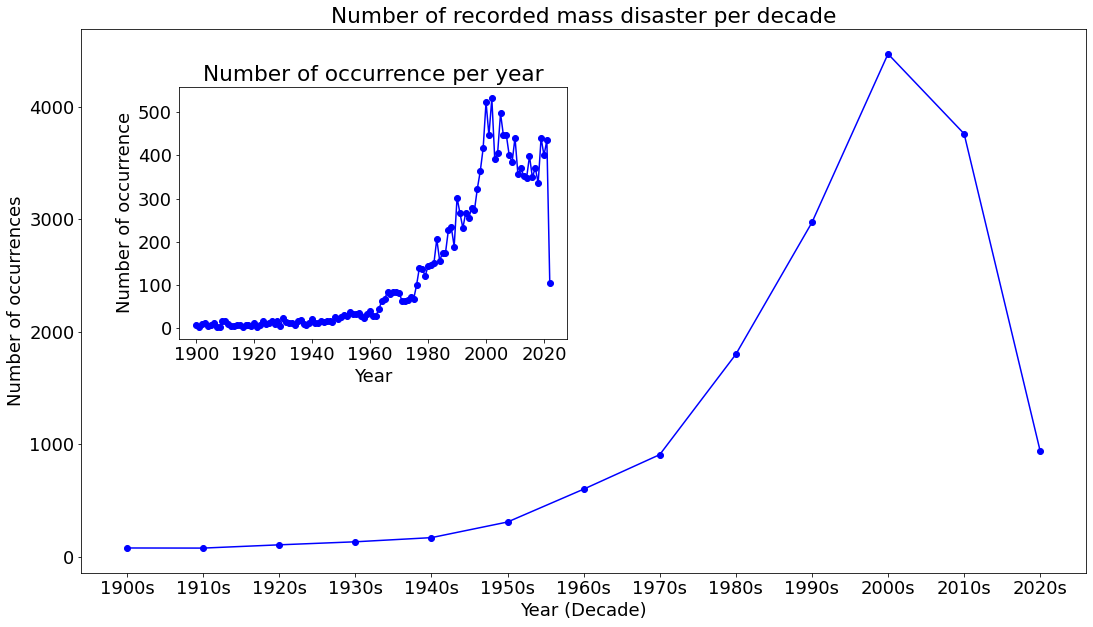

In [13]:
# Plot figure
fig, ax1 = plt.subplots(figsize=(18, 10))
left, bottom, width, height = [0.2,0.45,0.3,0.35]
ax2 = fig.add_axes([left, bottom, width, height])

labels = ['1900s','1910s','1920s', '1930s', 
          '1940s', '1950s','1960s', '1970s', 
          '1980s', '1990s', '2000s', '2010s', 
          '2020s'
          ]

# Convert to Pandas, sort values & set index
grp_dec_pdf = grp_dec_df.toPandas()
grp_yr_pdf = grp_yr_df.toPandas()
grp_yr_pdf = grp_yr_pdf.sort_values(by = 'year').set_index('year')
grp_dec_pdf = grp_dec_pdf.sort_values(by = 'year_in_decade').set_index('year_in_decade')


# Big plot
grp_dec_pdf['no_occurrence'].plot(marker = 'o', color = 'b', legend = None,
                                     linewidth = 1.5, ax = ax1)
ax1.set_title('Number of recorded mass disaster per decade')
ax1.set_xlabel('Year (Decade)')
ax1.set_ylabel('Number of occurrences')
ax1.set_xticks(list(grp_dec_pdf.index))
ax1.set_xticklabels(labels)

# Inset
grp_yr_pdf['no_occurrence'].plot(marker = 'o', color = 'b', legend = None, linewidth = 1.5, ax = ax2)
ax2.set_title('Number of occurrence per year')
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of occurrence')

plt.savefig('../img/fig1a.png')

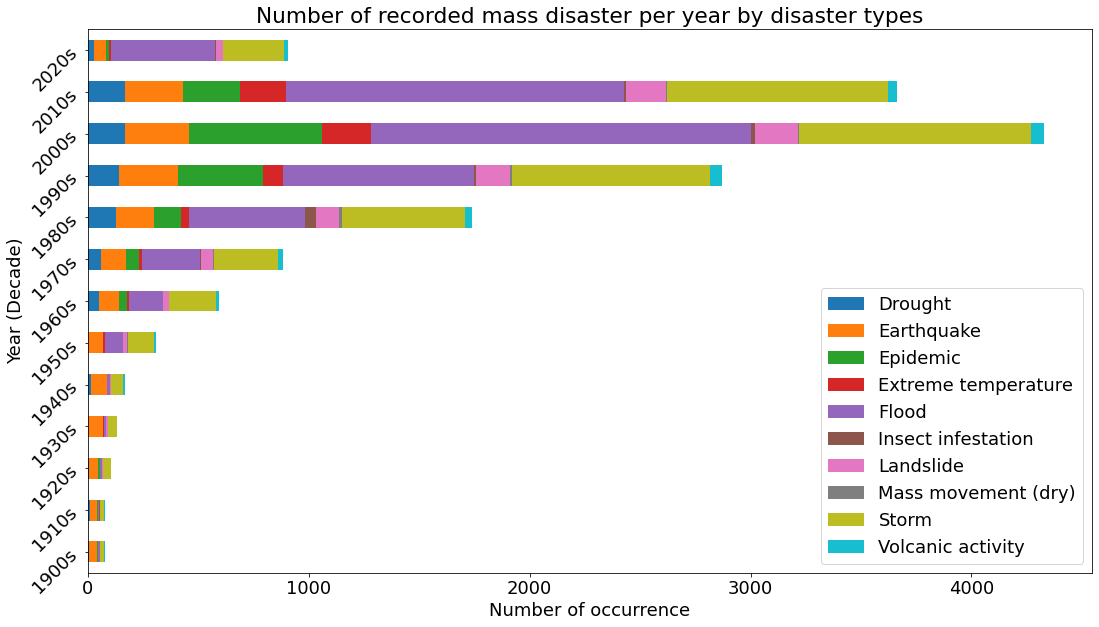

In [14]:
fig, ax = plt.subplots(figsize=(18, 10))

pvt = df.groupBy('year_in_decade')\
    .pivot('disaster_type')\
    .agg(count('no_occurrence')
    ).toPandas()
pvt = pvt.sort_values(by = 'year_in_decade').set_index('year_in_decade')
pvt.drop(['Animal accident', 'Fog', 'Impact', 'Glacial lake outburst', 'Wildfire'], axis =1, inplace=True)

# Plot figure
pvt.plot(kind = 'barh', stacked = True, ax = ax)
plt.title('Number of recorded mass disaster per year by disaster types')
plt.xlabel('Number of occurrence')
plt.ylabel('Year (Decade)')
ax.set_yticklabels(labels)
plt.yticks(rotation = 45)
plt.savefig('../img/fig1f.png')

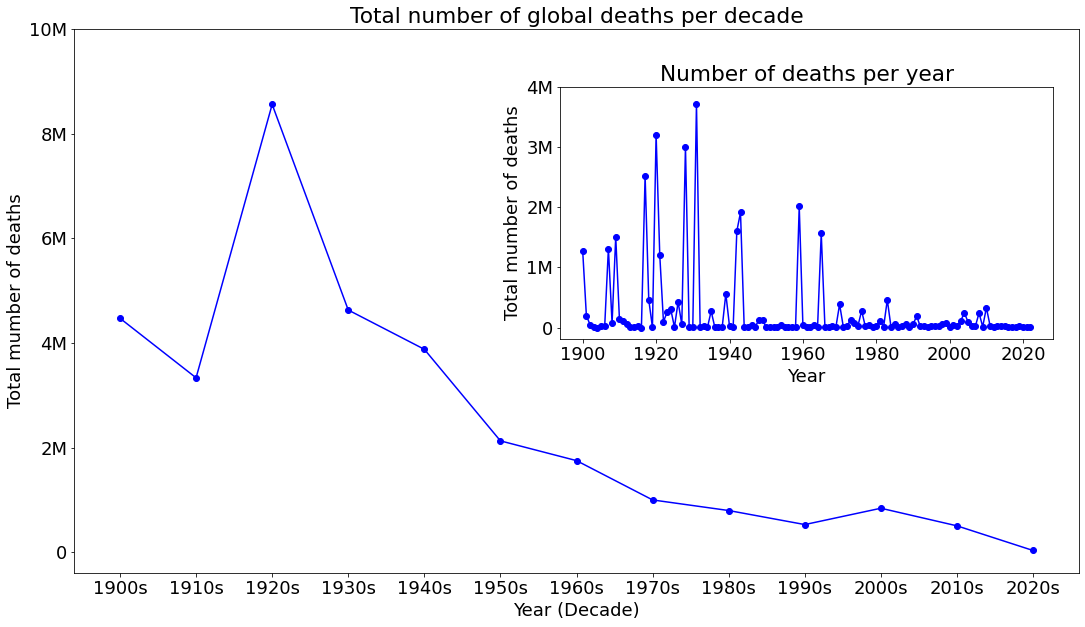

In [15]:
# Plot figure
fig, ax1 = plt.subplots(figsize=(18, 10))
left, bottom, width, height = [0.5,0.45,0.38,0.35]
ax2 = fig.add_axes([left, bottom, width, height])

 # Convert to Pandas, sort values & set index
grp_dec_pdf = grp_dec_df.toPandas()
grp_yr_pdf = grp_yr_df.toPandas()
grp_yr_pdf = grp_yr_pdf.sort_values(by = 'year').set_index('year')
grp_dec_pdf = grp_dec_pdf.sort_values(by = 'year_in_decade').set_index('year_in_decade')

ylabels = ['0','2M','4M', '6M', '8M', '10M']

# Big plot
grp_dec_pdf['total_deaths'].plot(marker = 'o', color = 'b', 
                            legend = None, linewidth = 1.5, ax = ax1)
ax1.set_title('Total number of global deaths per decade')
ax1.set_xlabel('Year (Decade)')
ax1.set_ylabel('Total mumber of deaths')
ax1.set_xticks(list(grp_dec_pdf.index))
ax1.set_xticklabels(labels)
ax1.set_yticks(np.arange(0,12000000,2000000))
ax1.set_yticklabels(ylabels)

# Inset
ylabels = ['0','1M','2M', '3M', '4M']

grp_yr_pdf['total_deaths'].plot(marker = 'o', color = 'b', legend = None, linewidth = 1.5, ax = ax2)
ax2.set_title('Number of deaths per year')
ax2.set_xlabel('Year')
ax2.set_ylabel('Total mumber of deaths')
ax2.set_yticks(np.arange(0,5000000,1000000))
ax2.set_yticklabels(ylabels)
plt.savefig('../img/fig1b.png')

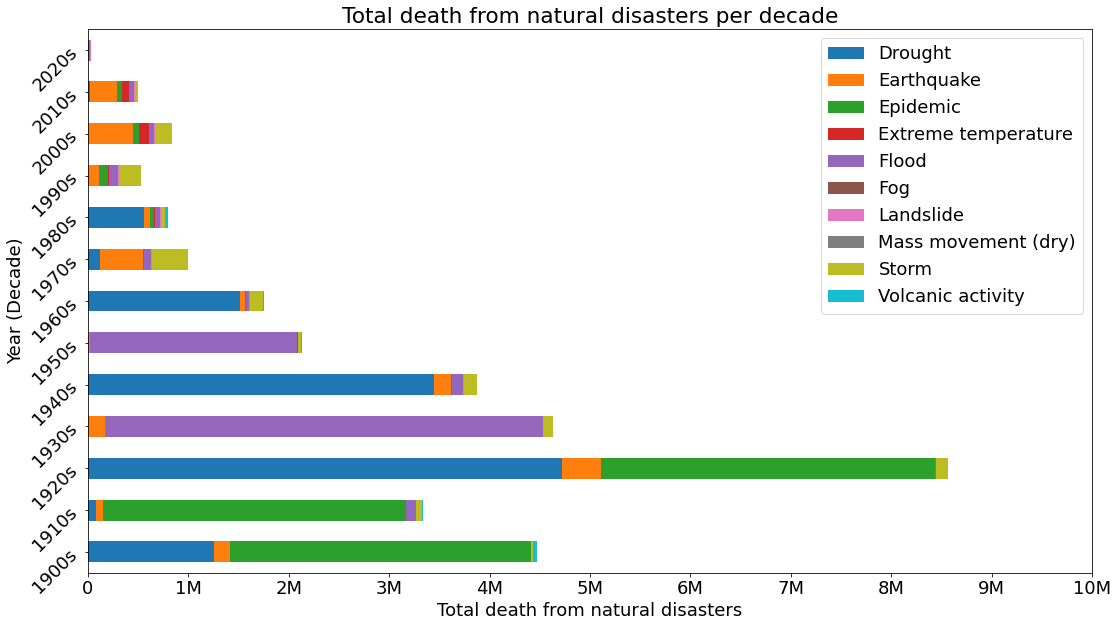

In [16]:
fig, ax = plt.subplots(figsize=(18, 10))

pvt_death_pdf = df.groupBy('year_in_decade')\
    .pivot('disaster_type')\
    .agg(sum('total_deaths')
    ).toPandas()

pvt_death_pdf = pvt_death_pdf.sort_values(by = 'year_in_decade').set_index('year_in_decade')
pvt_death_pdf.drop(['Animal accident', 'Insect infestation', 
                    'Impact', 'Glacial lake outburst', 'Wildfire'
                   ], axis=1, inplace=True)

xlabels = ['0','1M','2M', '3M', '4M', '5M','6M','7M', '8M', '9M', '10M']

# Plot figure
pvt_death_pdf.plot(kind = 'barh', stacked = True, ax = ax)
plt.title('Total death from natural disasters per decade')
plt.xlabel('Total death from natural disasters')
plt.ylabel('Year (Decade)')
ax.set_yticklabels(labels)
ax.set_xticks(np.arange(0,11000000,1000000))
ax.set_xticklabels(xlabels)
plt.yticks(rotation = 45)
plt.savefig('../img/fig1.png')

In [17]:
pdf_bubble = df.groupBy('year')\
    .pivot('disaster_type')\
    .agg(sum('total_deaths')
    ).toPandas()
    
pdf_bubble.set_index('year', inplace=True)
pdf_bubble = pdf_bubble.unstack().dropna().reset_index()
pdf_bubble.columns = ['disaster_type', 'year', 'total_deaths']
pdf_bubble.sort_values(by = 'total_deaths', ascending=True,inplace=True)

In [18]:
pdf_bubble.tail()

,disaster_type,year,total_deaths
297,Flood,1959,2003396.0
210,Epidemic,1920,2500000.0
180,Epidemic,1917,2500000.0
41,Drought,1928,3000000.0
358,Flood,1931,3700000.0


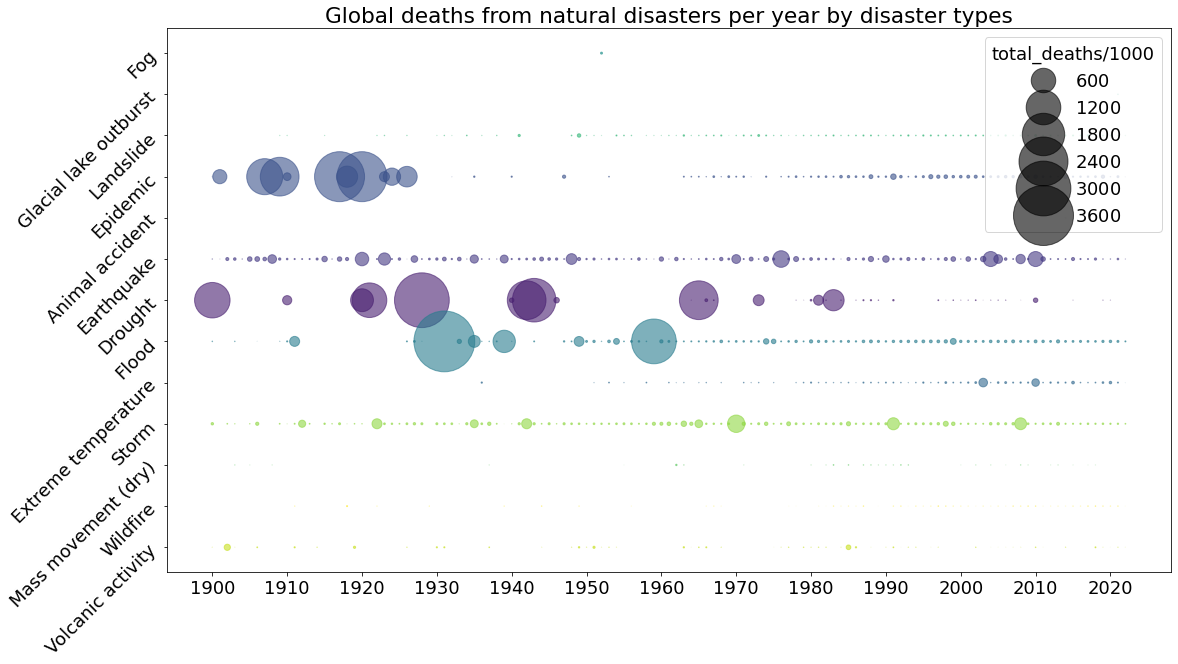

In [19]:
plt.subplots(figsize=(18, 10))
sc = plt.scatter(pdf_bubble["year"], pdf_bubble["disaster_type"], 
                 s = pdf_bubble['total_deaths']/1000, alpha=0.6, 
                 c = pd.Categorical(pdf_bubble['disaster_type']).codes
)
plt.yticks(rotation = 45)
plt.xticks(np.arange(1900,2030,10))
plt.title('Global deaths from natural disasters per year by disaster types')
handles, labels_ = sc.legend_elements(prop="sizes", num = 6, alpha=0.6)
plt.legend(handles, labels_, loc="upper right", title="total_deaths/1000")
# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=17)
plt.savefig('../img/fig_bb.png')

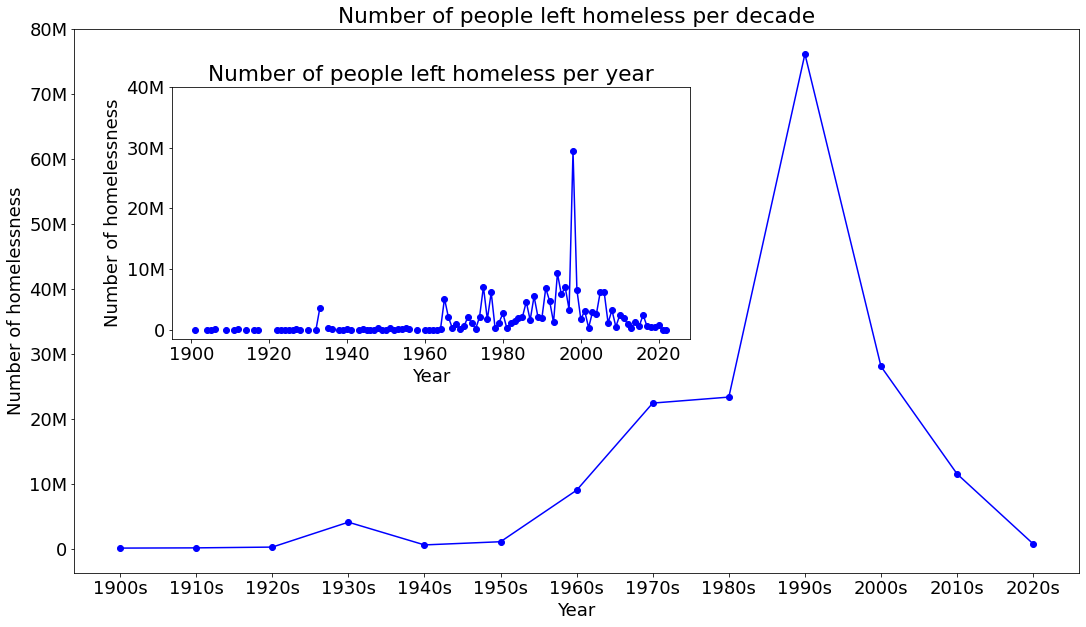

In [20]:
# Plot figure
fig, ax1 = plt.subplots(figsize=(18, 10))
left, bottom, width, height = [0.2,0.45,0.4,0.35]
ax2 = fig.add_axes([left, bottom, width, height])

 # Convert to Pandas, sort values & set index
grp_dec_pdf = grp_dec_df.toPandas()
grp_yr_pdf = grp_yr_df.toPandas()
grp_yr_pdf = grp_yr_pdf.sort_values(by = 'year').set_index('year')
grp_dec_pdf = grp_dec_pdf.sort_values(by = 'year_in_decade').set_index('year_in_decade')

ylabels = ['0','10M','20M', '30M', '40M', '50M','60M','70M', '80M']

# Big plot
grp_dec_pdf['total_homeless'].plot( marker = 'o', color = 'b', legend = None, linewidth = 1.5, ax = ax1)
ax1.set_title('Number of people left homeless per decade')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of homelessness')
ax1.set_xticks(list(grp_dec_pdf.index))
ax1.set_xticklabels(labels)
ax1.set_yticks(np.arange(0,90000000,10000000))
ax1.set_yticklabels(ylabels)

# Inset
ylabels = ['0','10M','20M', '30M', '40M']

grp_yr_pdf['total_homeless'].plot( marker = 'o', color = 'b', legend = None, linewidth = 1.5, ax = ax2)
ax2.set_title('Number of people left homeless per year')
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of homelessness')
ax2.set_yticks(np.arange(0,50000000,10000000))
ax2.set_yticklabels(ylabels)
plt.savefig('../img/fig1c.png')

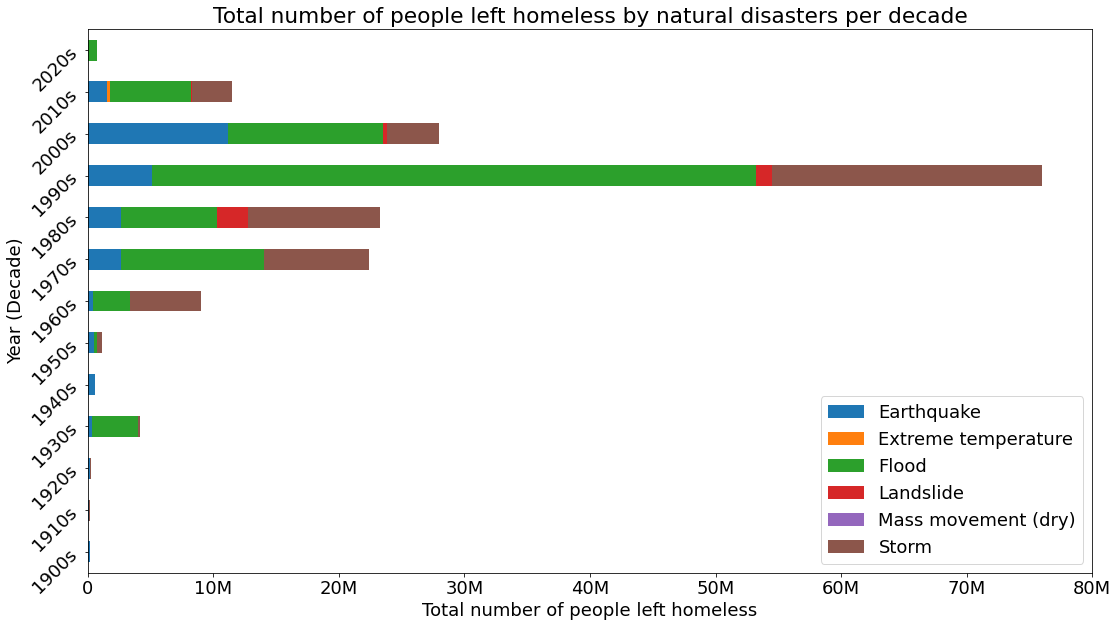

In [21]:
fig, ax = plt.subplots(figsize=(18, 10))

pvt = df.groupBy('year_in_decade')\
    .pivot('disaster_type')\
    .agg(sum('no_homeless')
    ).toPandas()
pvt = pvt.sort_values(by = 'year_in_decade').set_index('year_in_decade')
pvt.drop(['Animal accident',  'Epidemic', 'Insect infestation', 
          'Impact', 'Glacial lake outburst','Wildfire', 'Drought', 
          'Fog', 'Volcanic activity'], axis=1, inplace=True)

xlabels = ['0','10M','20M', '30M', '40M', '50M','60M','70M', '80M']

# Plot figure
pvt.plot(kind = 'barh', stacked = True, ax = ax)
plt.title('Total number of people left homeless by natural disasters per decade')
plt.xlabel('Total number of people left homeless')
plt.ylabel('Year (Decade)')
ax.set_yticklabels(labels)
ax.set_xticks(np.arange(0,90000000,10000000))
ax.set_xticklabels(xlabels)
plt.yticks(rotation = 45)
plt.savefig('../img/fig1e.png')

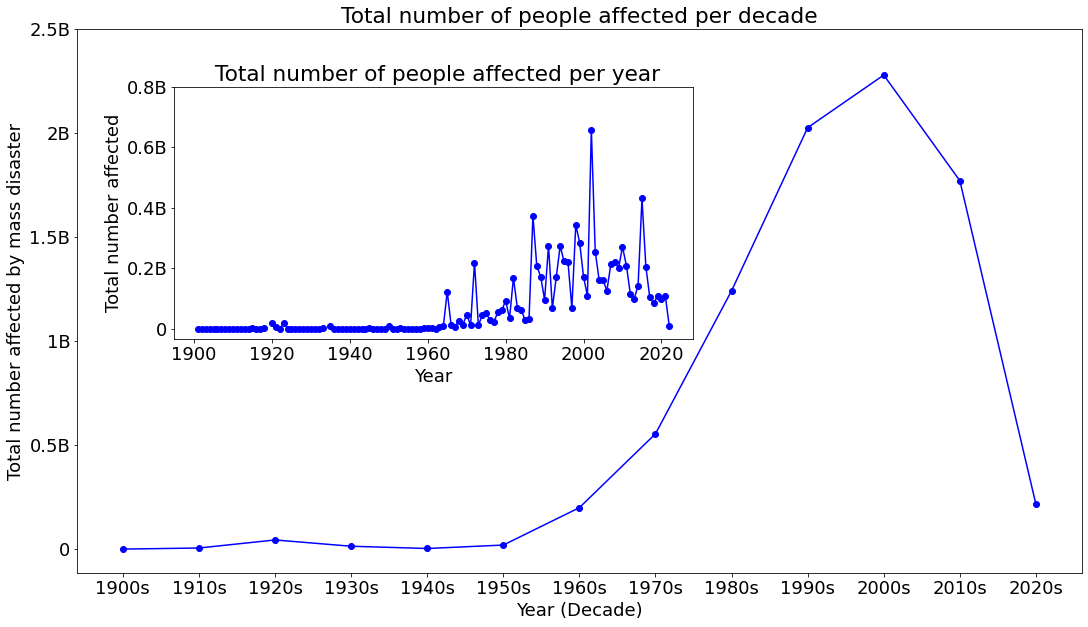

In [22]:
# Plot figure
fig, ax1 = plt.subplots(figsize=(18, 10))
left, bottom, width, height = [0.2,0.45,0.4,0.35]
ax2 = fig.add_axes([left, bottom, width, height])

 # Convert to Pandas, sort values & set index
grp_dec_pdf = grp_dec_df.toPandas()
grp_yr_pdf = grp_yr_df.toPandas()
grp_yr_pdf = grp_yr_pdf.sort_values(by = 'year').set_index('year')
grp_dec_pdf = grp_dec_pdf.sort_values(by = 'year_in_decade').set_index('year_in_decade')

ylabels = ['0','0.5B','1B', '1.5B', '2B', '2.5B']

# Big plot
grp_dec_pdf['total_affected'].plot(marker = 'o', color = 'b', legend=None, linewidth=1.5, ax=ax1)
ax1.set_title('Total number of people affected per decade')
ax1.set_xlabel('Year (Decade)')
ax1.set_ylabel('Total number affected by mass disaster')
ax1.set_xticks(list(grp_dec_pdf.index))
ax1.set_xticklabels(labels)
ax1.set_yticks(np.arange(0,3000000000,500000000))
ax1.set_yticklabels(ylabels)

# Inset
ylabels = ['0','0.2B','0.4B', '0.6B', '0.8B']

grp_yr_pdf['total_affected'].plot(marker = 'o', color = 'b', legend = None, linewidth = 1.5, ax=ax2)
ax2.set_title(' Total number of people affected per year')
ax2.set_xlabel('Year')
ax2.set_ylabel('Total number affected')
ax2.set_yticks(np.arange(0,900000000,200000000))
ax2.set_yticklabels(ylabels)
plt.savefig('../img/fig1d.png')

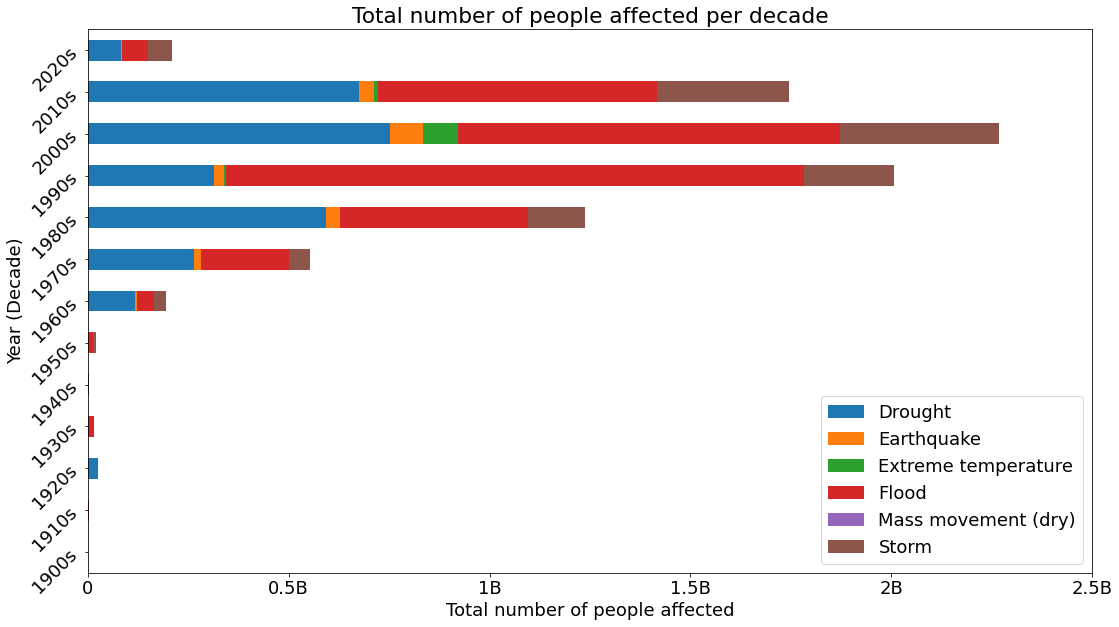

In [23]:
fig, ax = plt.subplots(figsize=(18, 10))

pvt = df.groupBy('year_in_decade')\
    .pivot('disaster_type')\
    .agg(sum('total_affected')
    ).toPandas()
pvt = pvt.sort_values(by = 'year_in_decade').set_index('year_in_decade')
pvt.drop(['Animal accident',  'Epidemic', 'Insect infestation', 
          'Impact', 'Glacial lake outburst', 'Wildfire', 'Fog', 
          'Volcanic activity', 'Landslide'], axis =1, inplace=True)

xlabels = ['0','0.5B','1B', '1.5B', '2B', '2.5B']

# Plot figure
pvt.plot(kind = 'barh', stacked = True, ax = ax)
plt.title('Total number of people affected per decade')
plt.xlabel('Total number of people affected')
plt.ylabel('Year (Decade)')
ax.set_yticklabels(labels)
ax.set_xticks(np.arange(0,3000000000,500000000))
ax.set_xticklabels(xlabels)
plt.yticks(rotation = 45)
plt.savefig('../img/fig1g.png')

In [27]:
df_sel = df.select(['year','year_in_decade', 'disaster_type']).toPandas()
occ_rate = pd.crosstab(df_sel.year_in_decade, df_sel.disaster_type, 
                       values=df_sel.year, aggfunc='count', normalize='index'
                      )

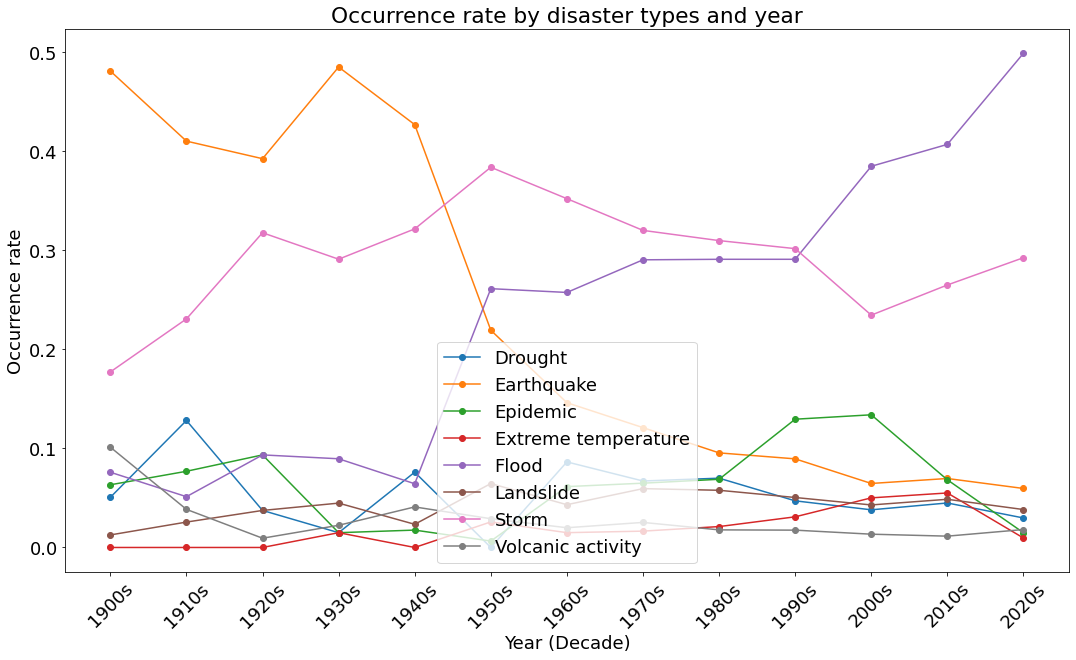

In [28]:
drop_list = ['Animal accident', 'Fog', 'Impact', 'Glacial lake outburst', 'Wildfire',
            'Insect infestation', 'Mass movement (dry)'
            ]
occ_rate.drop(drop_list, axis =1, inplace=True)

# Plot
occ_rate.plot(marker = 'o', figsize=(18,10))
plt.title('Occurrence rate by disaster types and year')
plt.xlabel('Year (Decade)')
plt.ylabel('Occurrence rate')
plt.xticks(list(occ_rate.index), labels, rotation = 45)
plt.legend(loc = 8)
plt.savefig('../img/fig2a.png')

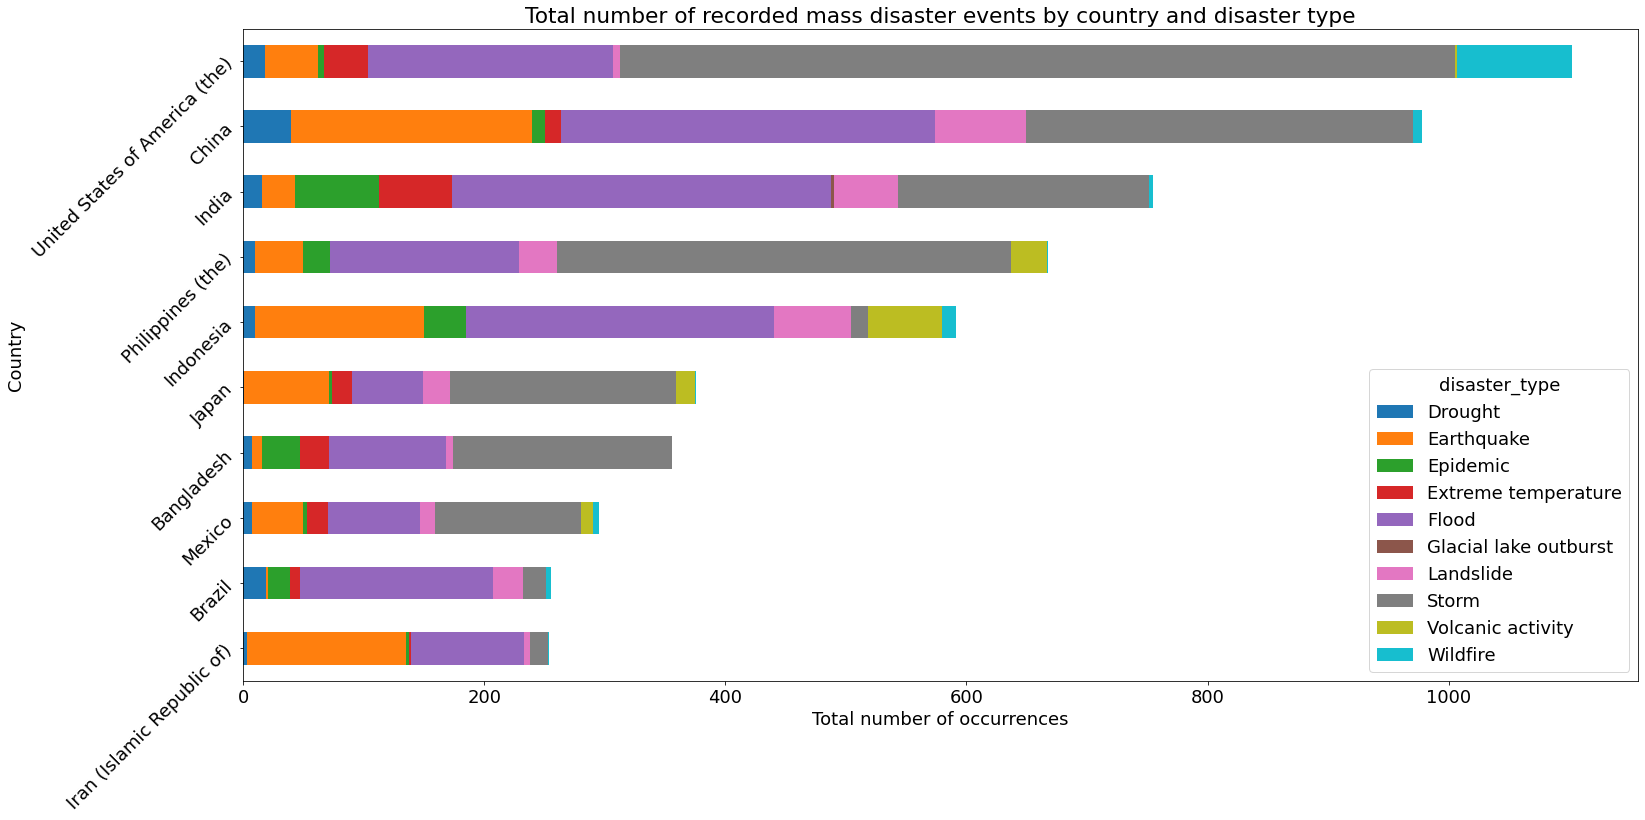

In [29]:
# Convert to Pandas, sort values & set index
pdf = df.toPandas()
pvt = pdf.pivot_table('no_occurrence', index= 'country', 
                      columns=['disaster_type'], 
                      aggfunc='count', margins=True)
pvt = pvt.sort_values(by = ['All'], ascending= True)
pvt.drop(['All', 'Animal accident', 'Mass movement (dry)', 
          'Insect infestation', 'Fog', 'Impact'], axis=1, inplace=True)
pvt.drop(['All'], axis=0, inplace = True)

# Plot
pvt.tail(10).plot(kind = 'barh',  stacked = True, figsize=(25,12))
plt.title('Total number of recorded mass disaster events by country and disaster type')
plt.xlabel('Total number of occurrences')
plt.ylabel('Country')
plt.yticks(rotation = 45)
plt.savefig('../img/fig2c.png')

# Economic cost of natural disasters

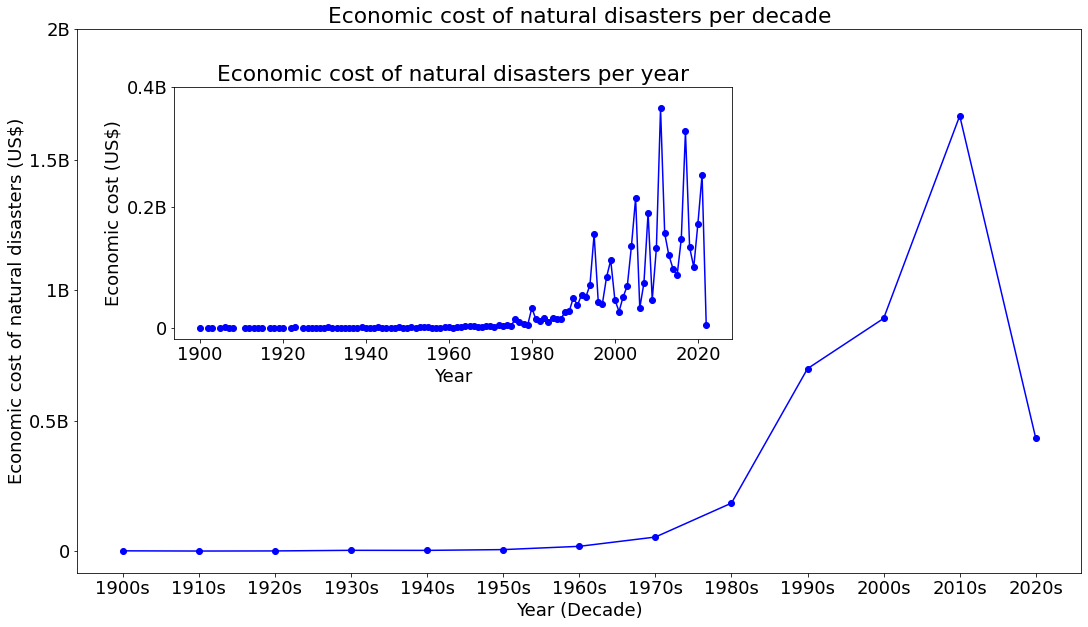

In [32]:
fig, ax1 = plt.subplots(figsize=(18, 10))
left, bottom, width, height = [0.2,0.45,0.43,0.35]
ax2 = fig.add_axes([left, bottom, width, height])

# Convert to Pandas, sort values & set index
grp_cst_pdf = df.groupBy('year')\
    .agg(sum("total_damages_('000_us$)").alias('total_damages_(us$)')
        ).toPandas()
        
grp_cst_dec_pdf = df.groupBy('year_in_decade')\
    .agg(sum("total_damages_('000_us$)").alias('total_damages_(us$)')
        ).toPandas()
grp_cst_pdf = grp_cst_pdf.sort_values(by = 'year').set_index('year')
grp_cst_dec_pdf = grp_cst_dec_pdf.sort_values(by = 'year_in_decade').set_index('year_in_decade')

ylabels = ['0','0.5B','1B', '1.5B', '2B']

# Big plot
grp_cst_dec_pdf.plot(marker = 'o', color = 'b',linewidth = 1.5, ax = ax1,  legend = None)
ax1.set_title('Economic cost of natural disasters per decade')
ax1.set_xlabel('Year (Decade)')
ax1.set_ylabel('Economic cost of natural disasters (US$)')
ax1.set_xticks(list(grp_cst_dec_pdf.index))
ax1.set_xticklabels(labels)
ax1.set_yticks(np.arange(0,2500000000,500000000))
ax1.set_yticklabels(ylabels)

# Inset
ylabels = ['0','0.2B','0.4B']
grp_cst_pdf.plot(marker = 'o', color = 'b', linewidth = 1.5, ax = ax2, legend = None)
ax2.set_title('Economic cost of natural disasters per year')
ax2.set_xlabel('Year')
ax2.set_ylabel('Economic cost (US$)')
ax2.set_yticks(np.arange(0,500000000,200000000))
ax2.set_yticklabels(ylabels)
plt.savefig('../img/fig3a.png')

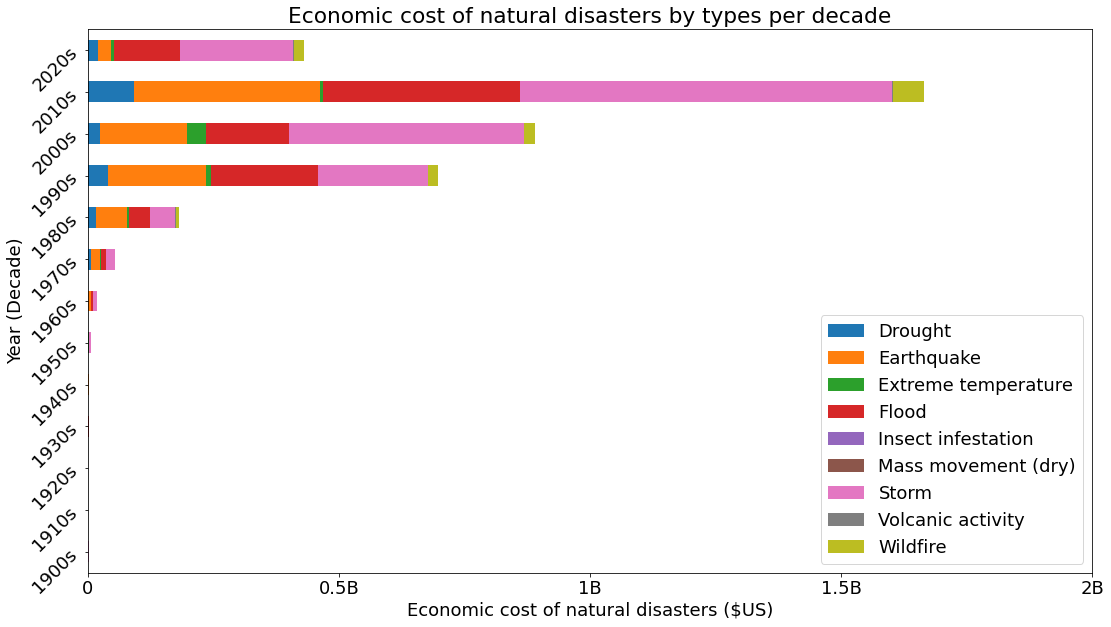

In [35]:
fig, ax = plt.subplots(figsize=(18, 10))

pvt_cst_pdf = df.groupBy('year_in_decade')\
    .pivot('disaster_type')\
    .agg(sum("total_damages_('000_us$)")
    ).toPandas()
pvt_cst_pdf = pvt_cst_pdf.sort_values(by = 'year_in_decade').set_index('year_in_decade')
pvt_cst_pdf.drop(['Animal accident', 'Fog', 'Impact',
                  'Glacial lake outburst', 'Epidemic', 
                  'Landslide'], axis =1, inplace=True)

xlabels = ['0','0.5B','1B', '1.5B', '2B']

# Plot figure
pvt_cst_pdf.plot(kind = 'barh', stacked = True, ax = ax)
plt.title('Economic cost of natural disasters by types per decade')
plt.xlabel('Economic cost of natural disasters ($US)')
plt.ylabel('Year (Decade)')
ax.set_yticklabels(labels, rotation = 45)
ax.set_xticks(np.arange(0,2500000000,500000000))
ax.set_xticklabels(xlabels)
plt.legend(loc = 4)
plt.savefig('../img/fig3b.png')

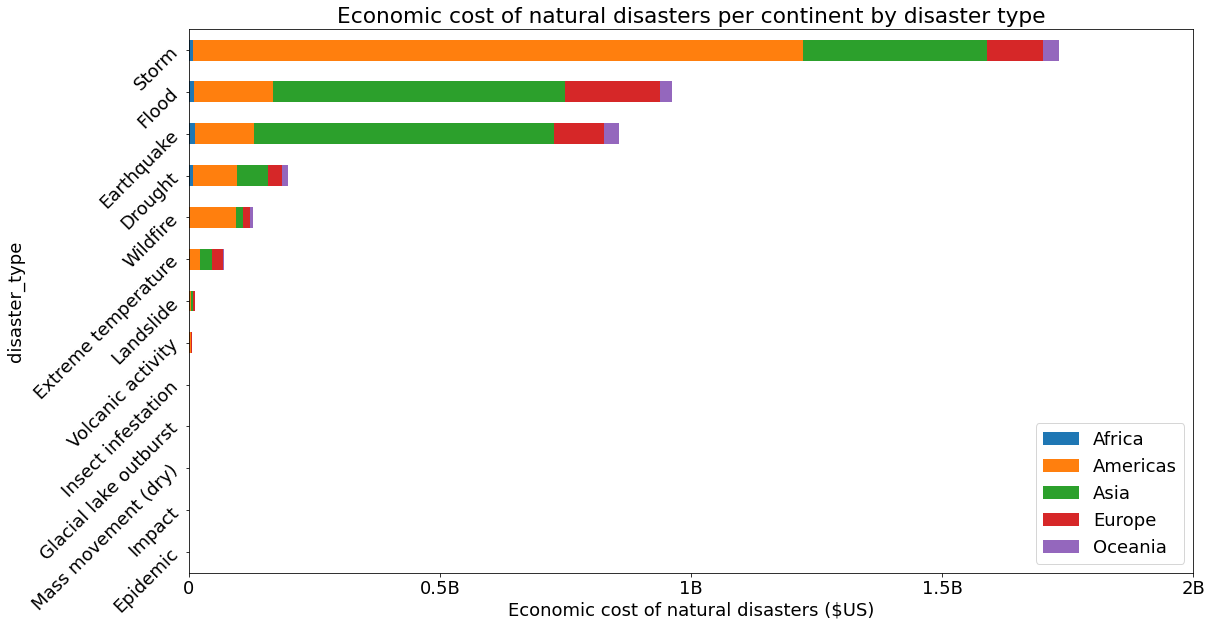

In [37]:
fig, ax = plt.subplots(figsize=(18,10))

pvt2_cst_pdf = df.toPandas().pivot_table("total_damages_('000_us$)", index= 'disaster_type', 
                                         columns= ['continent'], aggfunc='sum', 
                                         margins= True)
pvt2_cst_pdf = pvt2_cst_pdf.sort_values(by = ['All'], ascending= True)
pvt2_cst_pdf.drop(['All'], axis=1, inplace = True)
pvt2_cst_pdf.drop(['All', 'Fog', 'Animal accident'], axis=0, inplace = True)

xlabels = ['0','0.5B','1B', '1.5B', '2B']

# Plot figure
pvt2_cst_pdf.plot(kind = 'barh', stacked = True, ax = ax)
plt.title('Economic cost of natural disasters per continent by disaster type')
plt.xlabel('Economic cost of natural disasters ($US)')
ax.set_xticks(np.arange(0,2500000000,500000000))
ax.set_xticklabels(xlabels)
plt.yticks(rotation = 45)
plt.legend(loc = 4)
plt.savefig('../img/fig3c.png')

# Trends of Disaster types

In [38]:
# Pivot by disaster type
pvt2_df = df.groupBy('disaster_type')\
    .pivot('continent')\
    .agg(avg('no_occurrence')
    )

pvt3_df = df.groupBy('disaster_type')\
    .pivot('continent')\
    .agg(count('total_deaths')
    )

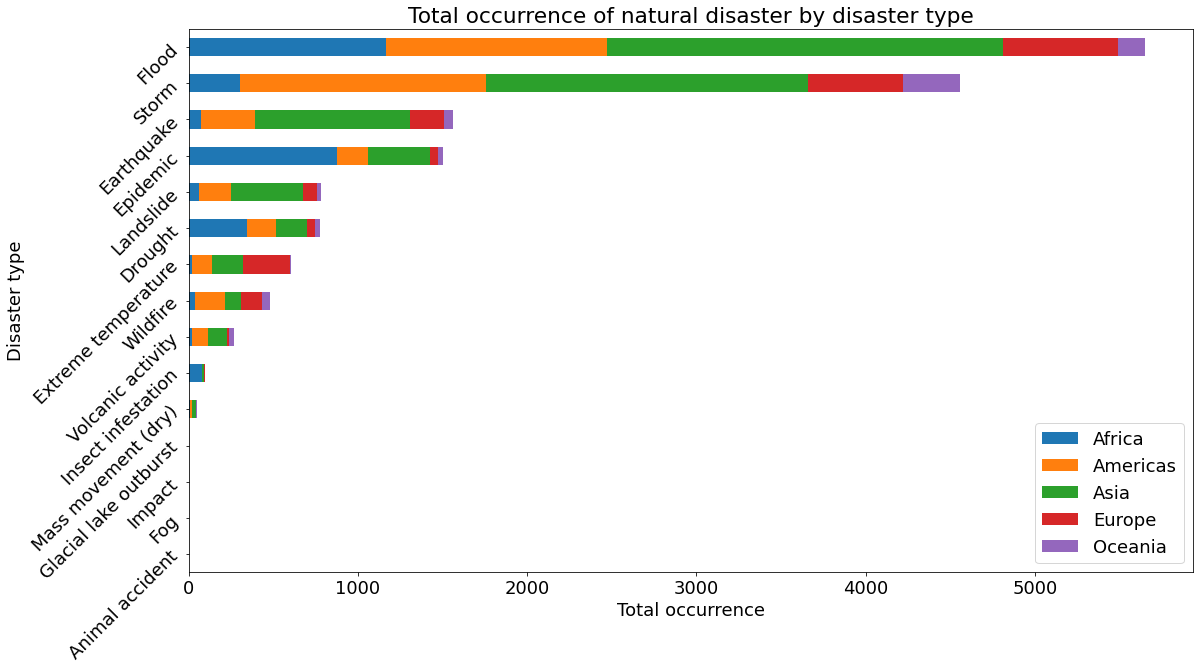

In [39]:
# Convert to Pandas, sort values & set index
pdf = df.toPandas()
pvt = pdf.pivot_table('no_occurrence', index= 'disaster_type',
                      columns= ['continent'], aggfunc = 'count',
                      margins= True)
pvt = pvt.sort_values(by = ['All'], ascending= True)
pvt.drop(['All'], axis=1, inplace = True)
pvt.drop(['All'], axis=0, inplace = True)

# Plot figure
pvt.plot(kind = 'barh', stacked = True, figsize = (18, 10))
plt.title('Total occurrence of natural disaster by disaster type')
plt.xlabel('Total occurrence')
plt.ylabel('Disaster type')
plt.yticks(rotation = 45)
plt.legend(loc = 4)
plt.savefig('../img/fig4a.png')

# Trends by start hour

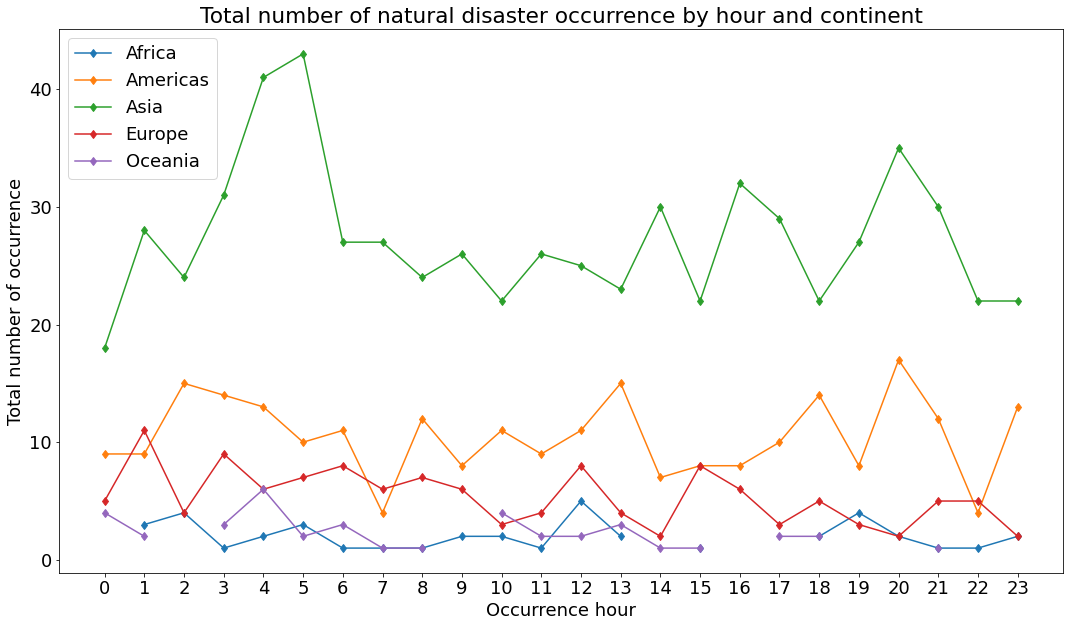

In [40]:
pdf_hour = df.groupBy('local_hour')\
    .pivot('continent')\
    .agg(count('no_occurrence').alias('no_occurrence')
    ).toPandas()

pdf_hour['local_hour'].dropna(inplace=True)
pdf_hour = pdf_hour.sort_values(by = 'local_hour').set_index('local_hour')

pdf_hour.plot(marker = 'd', figsize= (18,10), linewidth = 1.5)
plt.xticks(np.arange(0,24,1))
plt.xlabel('Occurrence hour')
plt.ylabel('Total number of occurrence')
plt.title('Total number of natural disaster occurrence by hour and continent')
plt.savefig('../img/fig6a.png')
plt.show()

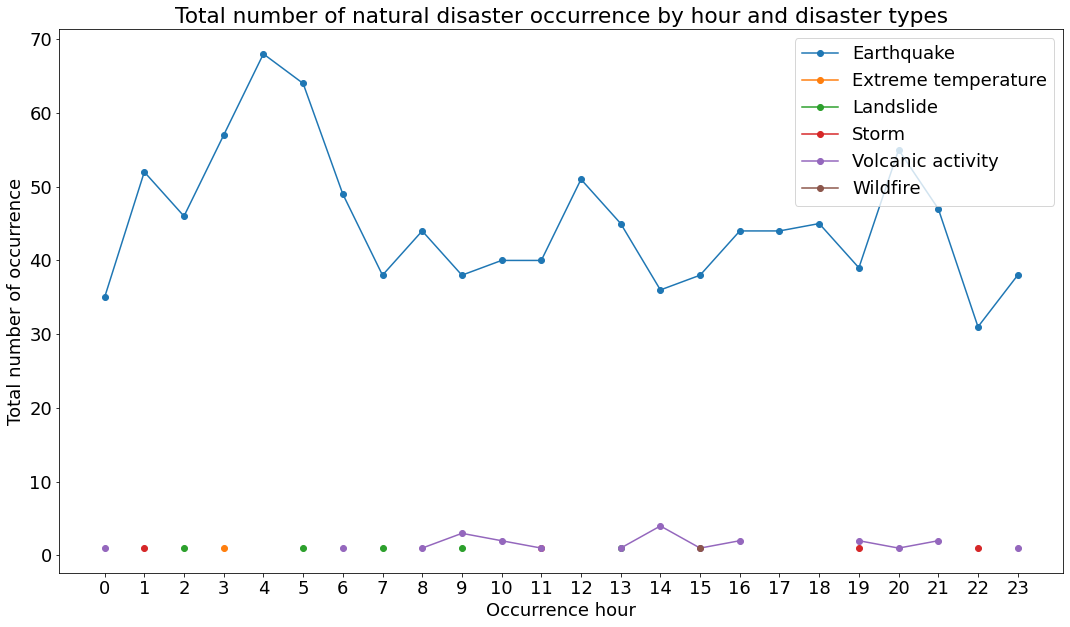

In [41]:
pdf_hour = df.groupBy('local_hour')\
    .pivot('disaster_type')\
    .agg(count('no_occurrence').alias('no_occurrence')
    ).toPandas()

no_val_list = ['Animal accident', 'Drought', 'Epidemic', 'Flood', 'Fog',
                'Glacial lake outburst', 'Insect infestation', 'Impact',
                'Mass movement (dry)']
pdf_hour['local_hour'].dropna(inplace=True)
pdf_hour.drop(no_val_list, axis = 1,inplace=True)
pdf_hour = pdf_hour.sort_values(by = 'local_hour').set_index('local_hour')

pdf_hour.plot(marker = 'o', figsize= (18,10), linewidth = 1.5)
plt.xticks(np.arange(0,24,1))
plt.xlabel('Occurrence hour')
plt.ylabel('Total number of occurrence')
plt.title('Total number of natural disaster occurrence by hour and disaster types')
plt.savefig('../img/fig6c.png')
plt.show()

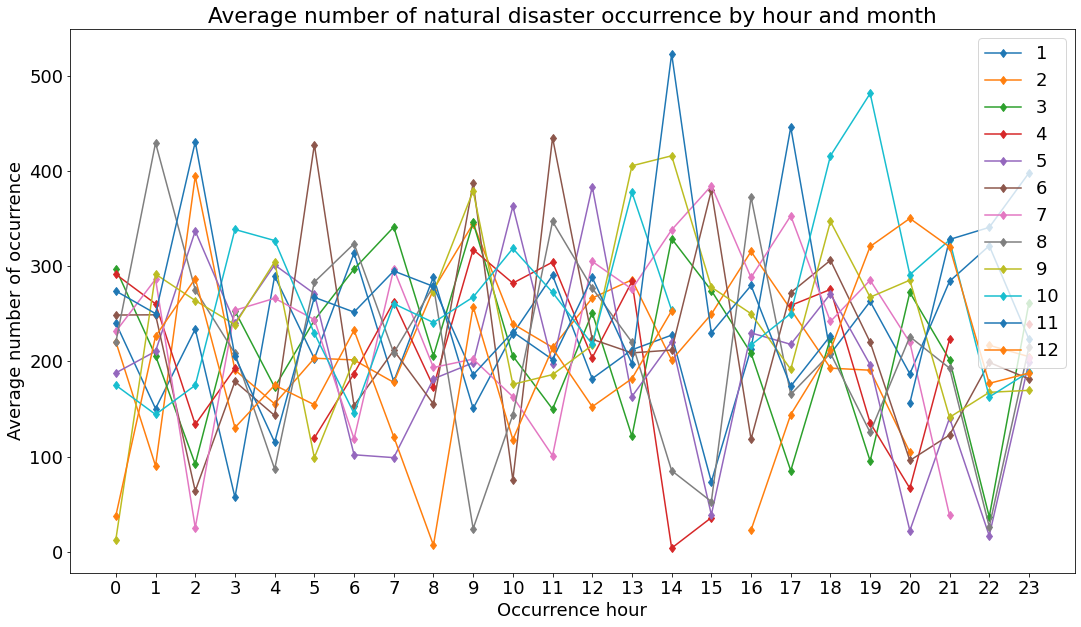

In [42]:
pdf_hour = df.groupBy('local_hour')\
    .pivot('start_month')\
    .agg(avg('no_occurrence').alias('no_occurrence')
    ).toPandas()

pdf_hour['local_hour'].dropna(inplace=True)
pdf_hour.drop('null', axis = 1,inplace=True)
pdf_hour = pdf_hour.sort_values(by = 'local_hour').set_index('local_hour')

pdf_hour.plot(marker = 'd', figsize= (18,10), linewidth = 1.5)
plt.xticks(np.arange(0,24,1))
plt.xlabel('Occurrence hour')
plt.ylabel('Average number of occurrence')
plt.title('Average number of natural disaster occurrence by hour and month')
plt.savefig('../img/fig6b.png')
plt.show()

# Trends by start month

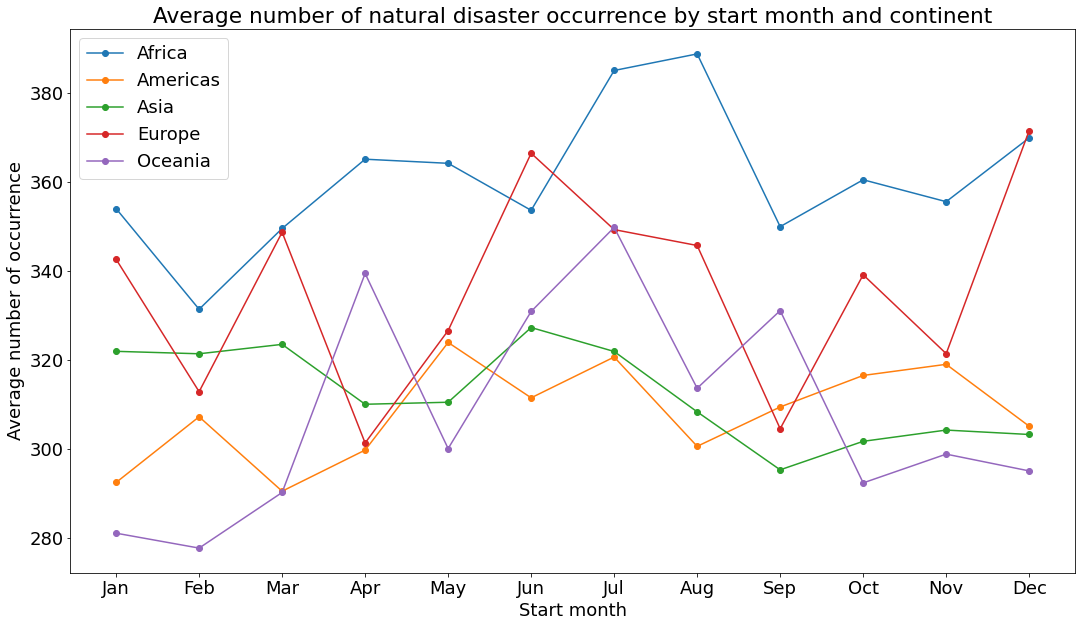

In [43]:
pdf_month = df.groupBy('start_month')\
    .pivot('continent')\
    .agg(avg('no_occurrence').alias('no_occurrence')
    ).toPandas()

labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

pdf_month['start_month'].dropna(inplace=True)
pdf_month = pdf_month.sort_values(by = 'start_month').set_index('start_month')

pdf_month.plot(marker = 'o', figsize= (18,10),linewidth = 1.5)
plt.xlabel('Start month')
plt.ylabel('Average number of occurrence')
plt.title('Average number of natural disaster occurrence by start month and continent')
plt.xticks(np.arange(1,13,1), labels)
plt.savefig('../img/fig7a.png')
plt.show()

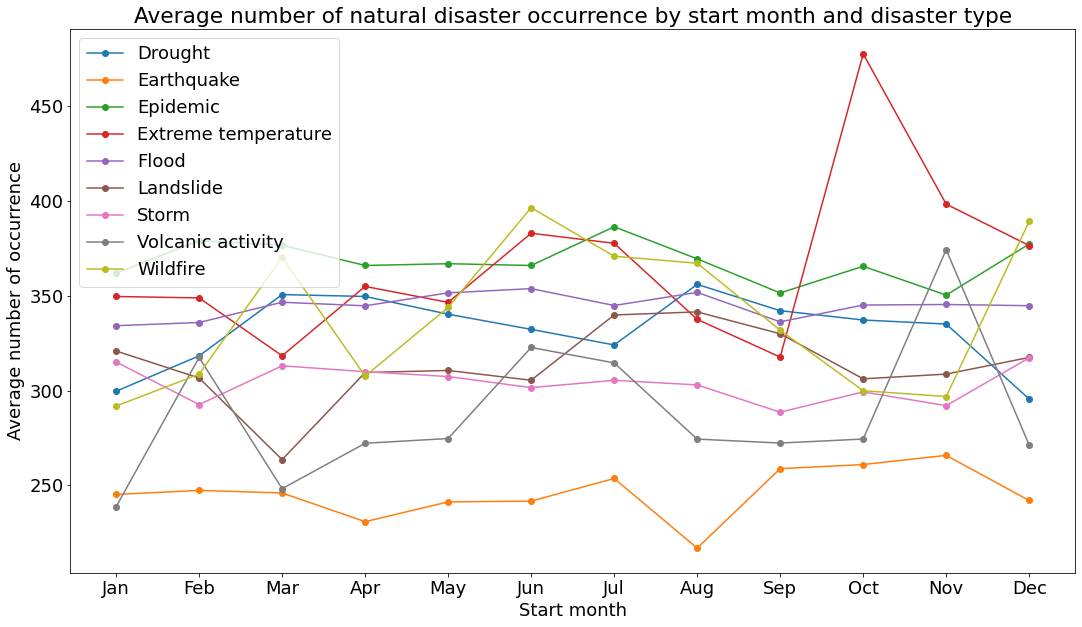

In [44]:
pdf_month = df.groupBy('start_month')\
    .pivot('disaster_type')\
    .agg(avg('no_occurrence').alias('no_occurrence')
    ).toPandas()

labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

small_val_list = ['Animal accident',  'Fog', 'Glacial lake outburst', 
'Insect infestation', 'Impact', 'Mass movement (dry)']

pdf_month['start_month'].dropna(inplace=True)
pdf_month = pdf_month.sort_values(by = 'start_month').set_index('start_month')
pdf_month.drop(small_val_list, axis = 1,inplace=True)

pdf_month.plot(marker = 'o', figsize= (18,10),linewidth = 1.5)
plt.xlabel('Start month')
plt.ylabel('Average number of occurrence')
plt.title('Average number of natural disaster occurrence by start month and disaster type')
plt.xticks(np.arange(1,13,1), labels)
plt.savefig('../img/fig7b.png')
plt.show()

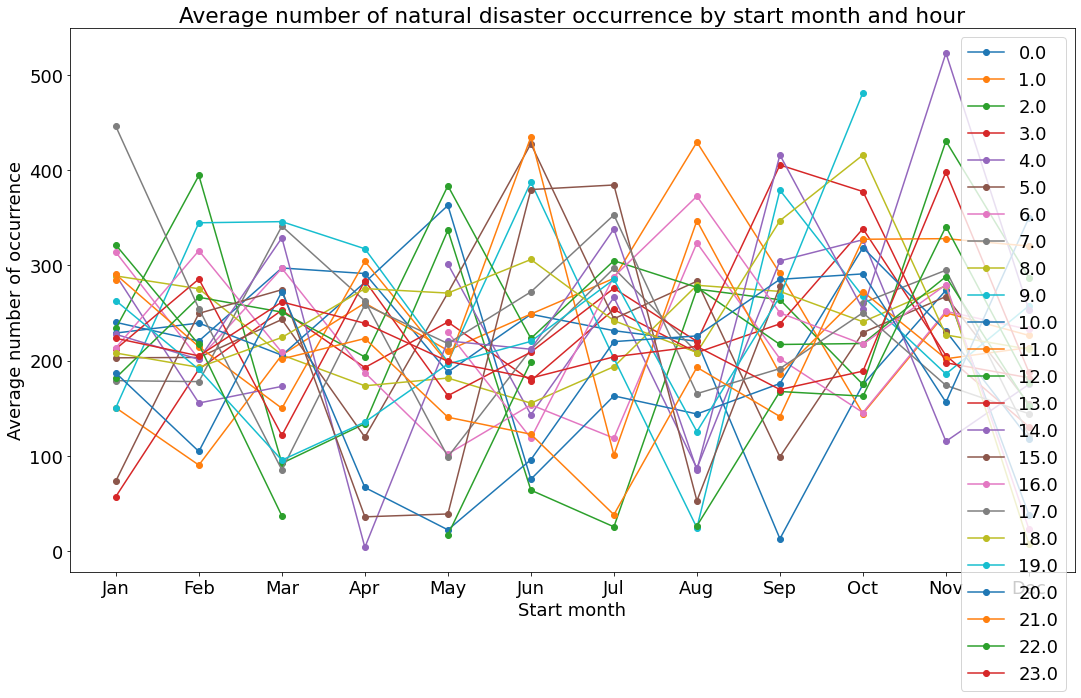

In [45]:
pdf_month = df.groupBy('start_month')\
    .pivot('local_hour')\
    .agg(avg('no_occurrence').alias('no_occurrence')
    ).toPandas()

labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

pdf_month['start_month'].dropna(inplace=True)
pdf_month.drop('null', axis = 1, inplace=True)
pdf_month = pdf_month.sort_values(by = 'start_month').set_index('start_month')

pdf_month.plot(marker = 'o', figsize= (18,10),linewidth = 1.5)
plt.xlabel('Start month')
plt.ylabel('Average number of occurrence')
plt.title('Average number of natural disaster occurrence by start month and hour')
plt.xticks(np.arange(1,13,1), labels)
plt.savefig('../img/fig7c.png')
plt.show()

# Histogram

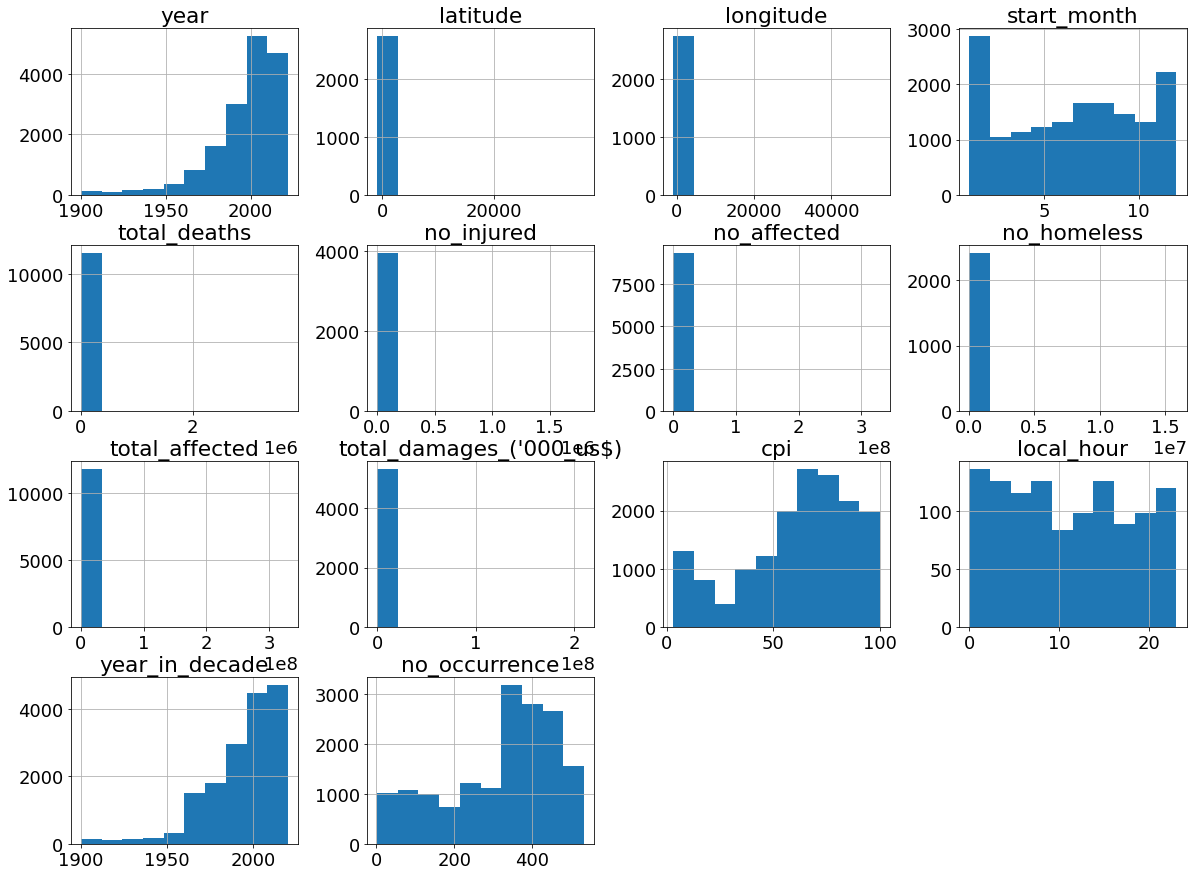

In [46]:
df.toPandas().hist(figsize= (20,15))
plt.show()